## code Vic -- add wearable data ##

In [ ]:
import glob
import json
import pandas as pd
import time
import datetime
from datetime import timezone

sheets = pd.read_csv("ids.csv")
BIOMETRIC_CSV_PATH = "../Biometrics/processed/"

for json_file in glob.glob("*/*.json"):
    with open(json_file, 'r') as f:
        data = json.load(f)

    for activity_timestamp in data["activityTimestamps"]:
        if activity_timestamp["name"] == "Sliders0":
            start = activity_timestamp["enter"]
        if activity_timestamp["name"] == "DASS":
            stop = activity_timestamp["leave"]
    
    room = int(sheets.loc[sheets['ID'] == data["id"]]["Kamer"].values[0])
    date_string = time.strftime('%d_%m_%Y', time.localtime(start/1000))

    chest_folder, left_folder, right_folder = "", "", ""
    for biometric_file in glob.glob(BIOMETRIC_CSV_PATH + date_string + "_*{}".format(room)):
        if "chest" in biometric_file:
            chest_folder = biometric_file
        elif "left" in biometric_file:
            left_folder = biometric_file
        elif "right" in biometric_file:
            right_folder = biometric_file

    if not (chest_folder and left_folder and right_folder):
        continue

    chest_frames = []
    left_frames = []  
    right_frames = []

    for chest_file in glob.glob(chest_folder + "/*.csv"):
        chest_frames.append(pd.read_csv(chest_file))

    for left_file in glob.glob(left_folder + "/*.csv"):
        left_frames.append(pd.read_csv(left_file))
    
    for right_file in glob.glob(right_folder + "/*.csv"):
        right_frames.append(pd.read_csv(right_file))

    chest = pd.concat(chest_frames)
    left = pd.concat(left_frames)
    right = pd.concat(right_frames)

    frames = {"chest": chest, "left" : left, "right" : right}
    for name, frame in frames.items():
        if(frame.shape[0] == 0 or frame.shape[1] == 0): continue
        frame[frame.columns[0]] = frame[frame.columns[0]].map(lambda x: int(datetime.datetime.strptime(x.split('.')[0], "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc).timestamp()) * 1000)
        frame.sort_values(by=[frame.columns[0]], inplace=True)
        frame.rename(columns={'Unnamed: 0': 'time'}, inplace=True)

        # Now find start and stop index of relevant data for this participant
        relevant = frame[(frame[frame.columns[0]] >= start) & (frame[frame.columns[0]] <= stop)]

        participant_dir = "/".join(json_file.split("/")[:-1])

        print("Saving cut out {} data for participant {}".format(name, data["id"]))
        relevant.to_csv(participant_dir + "/" + name + ".csv", index=False)

        

## code Ernest -- examine population (GSR) ##

In [1]:
import sys
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

class idData:
	def __init__(self, id, app_data, chest, left, right):
		self.id = id
		self.app_data = app_data
		self.chest = chest
		self.left = left
		self.right = right

# return timing intervals as indicated in appData.json
# labeled in unix timestamps
def get_timings(app_data):
	stamps = app_data['activityTimestamps']
	timings = []
	for s in stamps:
		t1 = s['enter']
		t2 = s['leave']
		timings.append(t1)
		timings.append(t2)
	return timings

# return timing intervals as indicated in appData.json
# labeled in minutes
def get_timings_min(app_data):
	stamps = app_data['activityTimestamps']
	timings = []
	for s in stamps:
		t1 = ((s['enter']/1000)/60) % 60
		t2 = ((s['leave']/1000)/60) % 60
		timings.append(t1)
		timings.append(t2)
	return timings

def draw_timings(plt, timings):
	plt.axvspan(timings[4], timings[5], alpha=0.2, color='green', label='Sliders')		# First sliders
	plt.axvspan(timings[6], timings[7], alpha=0.3, color='blue', label='Rest')			# First relax
	plt.axvspan(timings[8], timings[9], alpha=0.2, color='pink', label='Record')		# First record
	plt.axvspan(timings[10], timings[11], alpha=0.2, color='green')						# Second sliders
	plt.axvspan(timings[12], timings[13], alpha=0.2, color='red', label='MIST')			# MIST
	plt.axvspan(timings[14], timings[15], alpha=0.3, color='purple')					# Second record
	plt.axvspan(timings[16], timings[17], alpha=0.4, color='pink', label='Feedback')	# Feedback
	plt.axvspan(timings[18], timings[19], alpha=0.2, color='green') 					# Third sliders
	plt.axvspan(timings[20], timings[21], alpha=0.3, color='blue')						# Second relax
	plt.axvspan(timings[22], timings[23], alpha=0.2, color='green') 					# Fourth sliders
	plt.axvspan(timings[24], timings[25], alpha=0.25, color='green', label='RRS/DASS')	# PANAS
	plt.axvspan(timings[26], timings[27], alpha=0.25, color='green')					# DASS

# plot the ECG
def plot_ECG(data, scaling):
	print('Plotting ECG of id '+data.id)
	minutes = ((data.left['time']/1000)/60) % 60
	hours = (((data.left['time']/1000)/60)/60) % 24
	plt.figure(figsize=(15,8))
	plt.title('ECG of ID '+str(data.id),fontsize=22)
	plt.plot(data.chest['time'], data.chest['ECG_mean_heart_rate'],linewidth=2.0,color='black')
	xt = []
	xl = []
	c = 0
	for m in minutes:
		if m % 5 == 0:
			xt.append((data.chest['time'])[c])
			if m < 10:
				xl.append(str(int(hours[c]))+':0'+str(int(m))) # hh:mm label
			else:
				xl.append(str(int(hours[c]))+':'+str(int(m))) # hh:mm label
		c += 1
	plt.xticks(xt, xl)
	timings = get_timings(data.app_data)
	draw_timings(plt, timings)
	questions = (data.app_data['actualQuestions'])[0]
	plt.axvline(questions['start'], linestyle='--', color='black', label='Real MIST')
	plt.grid(True)
	plt.xlabel('Time of day (hours)', fontsize=18)
	plt.ylabel('ECG mean heart rate', fontsize=18)
	plt.legend(fontsize=14)
	plt.show()

# plot the EDA/GSR
# data is an idData instance
# scaling 'none', 'rest_normalized', 'normalized'
# no scaling plots GSR as is, 'normalized' scaled all data from 0 to 1
# and 'rest_normalized' sets the end of the first rest period to 1 with
# 0 at the lowest point before rest
# col selects what data to plot from the csv file (eg.: 'GSR_SCL')
# left and right are booleans to indicate data presence
def plot_GSR(data, scaling, col, left, right):
	print('Plotting GSR of id '+data.id)
	if left:
		minutes = ((data.left['time']/1000)/60) % 60
		hours = (((data.left['time']/1000)/60)/60) % 24
	elif right:
		minutes = ((data.right['time']/1000)/60) % 60
		hours = (((data.right['time']/1000)/60)/60) % 24
	plt.figure(figsize=(15,8))
	if data.app_data['rightHanded']:
		handedness = ' (Right-handed)'
	else:
		handedness = ' (Left-handed)'
	plt.title('EDA of ID '+str(data.id)+handedness,fontsize=22)
	if left:
		plt.plot(data.left['time'], data.left[col],linewidth=2.0,color='black', label='Left')
	if right:
		plt.plot(data.right['time'], data.right[col],linewidth=2.0,color='blue', label='Right')
	xt = []
	xl = []
	c = 0
	for m in minutes:
		if m % 5 == 0:
			xt.append((data.left['time'])[c])
			if m < 10:
				xl.append(str(int(hours[c]))+':0'+str(int(m))) # hh:mm label
			else:				
				xl.append(str(int(hours[c]))+':'+str(int(m))) # hh:mm label
		c += 1
	plt.xticks(xt, xl)
	timings = get_timings(data.app_data)
	draw_timings(plt, timings)
	questions = (data.app_data['actualQuestions'])[0]
	plt.axvline(questions['start'], linestyle='--', color='black', label='Real MIST')
	plt.grid(True)
	plt.xlabel('Time of day (hours)', fontsize=18)
	plt.ylabel(col, fontsize=18)
	plt.legend(fontsize=14)
	plt.show()

# plot a statistical population plot of GSR
# id_datas and ids to be considered
def plot_pop_GSR(id_datas, ids):
	all_data = pd.DataFrame()
	lengths = []
	longest_min = []
	for id in ids:
		gsr = id_datas[id].left

		# Cut GSR from beginning of first rest to end of PANAS
		minutes = ((gsr['time']/1000)/60) % 60
		timings = get_timings_min(id_datas[id].app_data)
		c = 0
		for m in minutes:
			if abs(timings[6]-m) <= 0.015: # Less than a second time difference
				start = c
			if abs(timings[25]-m) <= 0.015:
				end = c
			c += 1
		gsr = gsr[start:end]
		if len(minutes) > len(longest_min):
			longest_min = minutes-minutes[0] # Use a relative timescale, as long as the longest timeseries
		i = gsr['time'].index.values[0]
		gsr['time'] = gsr['time'] - (gsr['time'])[i]
		all_data = all_data.append(gsr)
		lengths.append(len(gsr))

	# Examine difference in GSR data length
	plt.hist(lengths)
	plt.title('Lengths of cut GSR data')
	plt.show()

	# Line plot with confidence interval
	all_data.set_index('time')
	ax = sns.lineplot(x='time', y='GSR_SCL', data=all_data)
	xl = [0, 5, 10, 15, 20, 25, 30]
	xt = np.multiply(xl, 60*1000)
	plt.xticks(xt, xl)
	plt.xlabel('Time since first rest started (minutes)', fontsize=18)
	plt.ylabel('GSR_SCL', fontsize=18)
	plt.grid(True)
	plt.show()

# Plot accelerometer data
def plot_acceleration(id_datas, id):
	print('')

# Sort IDs into invalid/uncertain/unstressed/stressed
def find_outliers(id_datas, chests, lefts, rights, completes):
	print('')

# Find possibly invalid GSR data
def find_outliers_GSR(id_datas, lefts, rights):
	invalids = []

	energies = []
	i = 0
	for id in lefts:
		data = id_datas[str(id)].left
		if (data['GSR_SCL'].values**2).sum(axis=0) < 7:
			invalids.append(id)
		i += 1
	i = 0
	for id in rights:
		data = id_datas[str(id)].right
		if (data['GSR_SCL'].values**2).sum(axis=0) < 7:
			invalids.append(id)
		i += 1

	print("Low energy: "+str(invalids))
	# Stay within 2 standard deviations

# Load all data

id_datas = {}	# Contains data objects of all valid IDs (own an appData file)
chests = []		# IDs who own chest.csv
lefts = []		# IDs who own left.csv
rights = [] 	# IDs who own right.csv
completes = []	# IDs who own all of the above

dir_names = next(os.walk('.'))[1]
print('Found '+str(len(dir_names))+' IDs.')

Found 153 IDs.


11 contains empty chest data
11 contains empty right data
13 contains empty right data
14 contains empty right data
16 contains empty chest data
16 contains empty right data
17 contains empty right data
21 contains empty right data
23 contains empty right data
26 contains empty right data
27 contains empty right data
29 contains empty right data
30 contains empty right data
32 contains empty right data
33 contains empty right data
36 contains empty right data
38 contains empty right data
40 contains empty right data
42 contains empty chest data
44 contains empty chest data
8 contains empty right data
83 contains empty right data
85 contains empty right data
9 contains empty right data
148 IDs contained appData.json
59 IDs contained all chest and bands data

Commands: plot (GSR|ECG|ACC) (ID|'all') ('none'|'rest_normalized'|'normalized') (column)

plot gsr 63
Plotting GSR of id 63


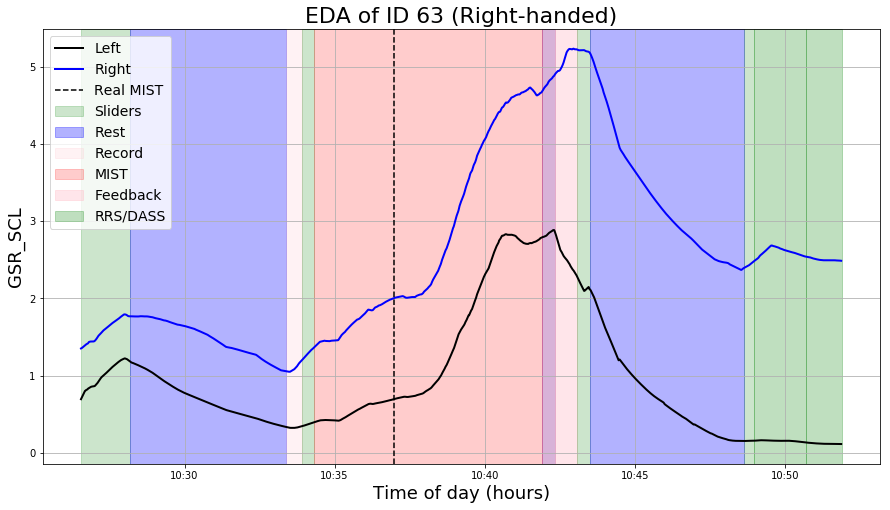

plot gsr 63
Plotting GSR of id 63


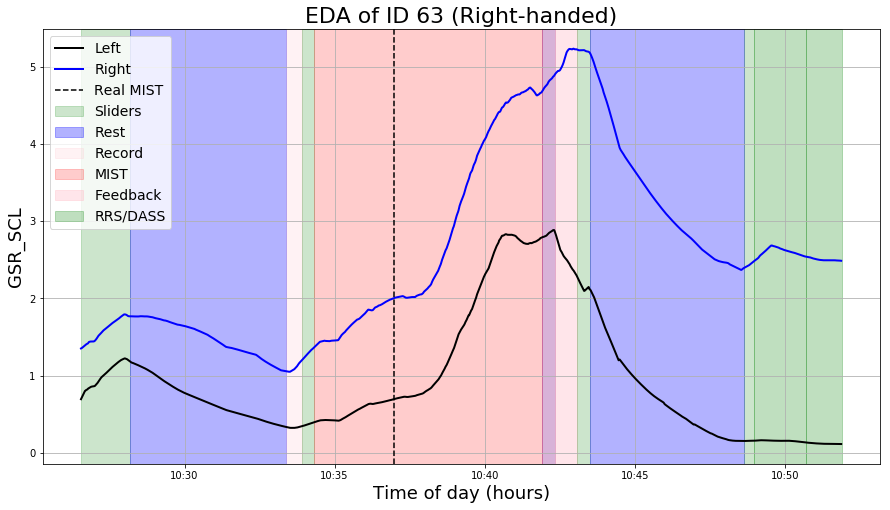

plot ecg 63
Plotting ECG of id 63


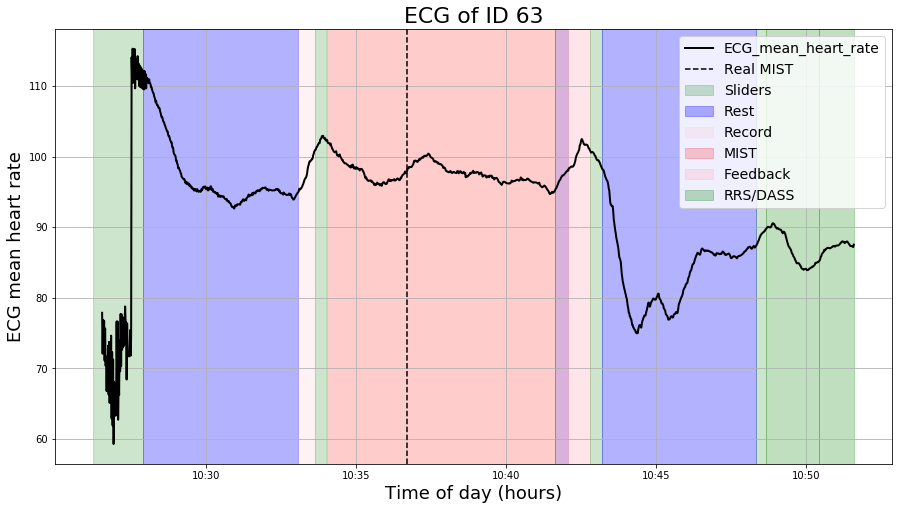

In [ ]:
# Loop folders
for id in dir_names:
	if os.path.isfile(os.path.join(id, 'appData.json')):
		with open(os.path.join(id,'appData.json')) as app_file:
			app_data_string = app_file.read()
			app_data = json.loads(app_data_string)
			data = idData(id, app_data, 'none', 'none', 'none')
		id_datas[id] = data

		# Check for and load CSV files
		complete = True
		if os.path.isfile(os.path.join(id, 'chest.csv')):
			chest = pd.read_csv(os.path.join(id, 'chest.csv'), sep=',')
			data.chest = chest
			if chest.empty:
				print(id + ' contains empty chest data')
			else:	
				chests.append(id)
		else:
			complete = False
		if os.path.isfile(os.path.join(id, 'left.csv')):
			left = pd.read_csv(os.path.join(id, 'left.csv'), sep=',')
			data.left = left
			if left.empty:
				print(id + ' contains empty left data')
			else:
				lefts.append(id)
		else:
			complete = False
		if os.path.isfile(os.path.join(id, 'right.csv')):
			right = pd.read_csv(os.path.join(id, 'right.csv'), sep=',')
			data.right = right
			if right.empty:
				print(id + ' contains empty right data')
			else:
				rights.append(id)
		else:
			complete = False
		if complete:
			completes.append(id)
		
print(str(len(id_datas))+' IDs contained appData.json')
print(str(len(completes))+' IDs contained all chest and bands data')

print('')
print("Commands: plot (GSR|ECG|ACC) (ID|'all') ('none'|'rest_normalized'|'normalized') (column)\n")

# Command loop for CLI
while True:
	x = input()
	cmd = x.split()
	
	if cmd[0].lower() == 'plot':
		if len(cmd) == 3:
			cmd.append('none')
		elif len(cmd) < 3:
			print('Not enough arguments')
			continue

		if cmd[1].lower() == "gsr":
			if cmd[2].lower() == 'all':
				# Plot population GSR
				plot_pop_GSR(id_datas, lefts)
			else:
				if len(cmd) < 5:
					cmd.append('GSR_SCL')
				id = cmd[2]
				# Plot GSR
				if (id in lefts) or (id in rights):
					plot_GSR(id_datas[id], cmd[3], cmd[4], (id in lefts), (id in rights))
		elif cmd[1].lower() == 'ecg':
			if cmd[2].lower() == 'all':
				# Plot population ECG
				plot_pop_ECG(id_datas, lefts)
			else:
				id = cmd[2]
				# Plot ECG
				if id in chests:
					plot_ECG(id_datas[id], cmd[3])
		elif cmd[1].lower() == 'acc':
			print('not yet implemented')
			continue
		else:
			print("I don't know what you want me to plot")
			continue
	elif cmd[0].lower() == 'find':
		if len(cmd) == 1:
			print('Not enough arguments')
			continue
		elif cmd[1].lower() == 'outliers':
			if len(cmd) < 3:
				find_outliers(id_datas, chests, lefts, rights, completes)
			else:
				if cmd[2].lower() == 'gsr':
					find_outliers_GSR(id_datas, lefts, rights)
				else:
					print("I don't know what you want me to find")
					continue
		else:
			print('Try: find outliers')
			continue

## genereer csv van json ##

In [ ]:
import glob
import json
import pandas as pd
import time
import datetime
import csv
import numpy as np
from datetime import timezone

sheets = pd.read_csv("ids.csv")

with open('dass.csv', 'w',newline='') as dassFile:
    dasswriter = csv.writer(dassFile, delimiter =';' )
    dasswriter.writerow(['ID','1','2','3','6','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21'])
    
with open('rrs.csv', 'w',newline='') as rrsFile:
    rrswriter = csv.writer(rrsFile, delimiter =';' )
    rrswriter.writerow(['ID','1','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','23','24','25','26'])

with open('vas.csv', 'w',newline='') as rrsFile:
    rrswriter = csv.writer(rrsFile, delimiter =';' )
    sliderrow=['ID','moe1','krachtig1','boos1','tevreden1','gespannen1','neerslachtig1','prettig1' ,'moe2','krachtig2','boos2','tevreden2','gespannen2','neerslachtig2','prettig2' , 'moe3','krachtig3','boos3','tevreden3','gespannen3','neerslachtig3','prettig3' ,'moe4','krachtig4','boos4','tevreden4','gespannen4','neerslachtig4','prettig4' ]
    rrswriter.writerow(sliderrow)

for json_file in glob.glob("*/*.json"):
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    IDnum = data["id"]
    
    dassrow = data["dass"]
    rrsrow = data["panas"]
    sliders = data["sliders"]  

    with open('dass.csv', 'a',newline='') as dassFile:
        dasswriter = csv.writer(dassFile, delimiter =';' )
        dasswriter.writerow([IDnum] + dassrow)
    
    with open('rrs.csv', 'a',newline='') as rrsFile:
        rrswriter = csv.writer(rrsFile, delimiter =';' )
        rrswriter.writerow([IDnum] + rrsrow)
        
    with open('vas.csv', 'a',newline='') as sliderFile:
        slidewriter = csv.writer(sliderFile, delimiter =';' )
        slidewriter.writerow([IDnum] + sliders[0] + sliders[1] + sliders[2] +sliders[3])


In [ ]:
# Loop folders
for id in dir_names:
	if os.path.isfile(os.path.join(id, 'appData.json')):
		with open(os.path.join(id,'appData.json')) as app_file:
			app_data_string = app_file.read()
			app_data = json.loads(app_data_string)
			data = idData(id, app_data, 'none', 'none', 'none')
		id_datas[id] = data

		# Check for and load CSV files
		complete = True
		if os.path.isfile(os.path.join(id, 'chest.csv')):
			chest = pd.read_csv(os.path.join(id, 'chest.csv'), sep=',')
			data.chest = chest
			if chest.empty:
				print(id + ' contains empty chest data')
			else:	
				chests.append(id)
		else:
			complete = False
		if os.path.isfile(os.path.join(id, 'left.csv')):
			left = pd.read_csv(os.path.join(id, 'left.csv'), sep=',')
			data.left = left
			if left.empty:
				print(id + ' contains empty left data')
			else:
				lefts.append(id)
		else:
			complete = False
		if os.path.isfile(os.path.join(id, 'right.csv')):
			right = pd.read_csv(os.path.join(id, 'right.csv'), sep=',')
			data.right = right
			if right.empty:
				print(id + ' contains empty right data')
			else:
				rights.append(id)
		else:
			complete = False
		if complete:
			completes.append(id)
		
print(str(len(id_datas))+' IDs contained appData.json')
print(str(len(completes))+' IDs contained all chest and bands data')

print('')
print("Commands: plot (GSR|ECG|ACC) (ID|'all') ('none'|'rest_normalized'|'normalized') (column)\n")

# Command loop for CLI
while True:
	x = input()
	cmd = x.split()
	
	if cmd[0].lower() == 'plot':
		if len(cmd) == 3:
			cmd.append('none')
		elif len(cmd) < 3:
			print('Not enough arguments')
			continue

		if cmd[1].lower() == "gsr":
			if cmd[2].lower() == 'all':
				# Plot population GSR
				plot_pop_GSR(id_datas, lefts)
			else:
				if len(cmd) < 5:
					cmd.append('GSR_SCL')
				id = cmd[2]
				# Plot GSR
				if (id in lefts) or (id in rights):
					plot_GSR(id_datas[id], cmd[3], cmd[4], (id in lefts), (id in rights))
		elif cmd[1].lower() == 'ecg':
			if cmd[2].lower() == 'all':
				# Plot population ECG
				plot_pop_ECG(id_datas, lefts)
			else:
				id = cmd[2]
				# Plot ECG
				if id in chests:
					plot_ECG(id_datas[id], cmd[3])
		elif cmd[1].lower() == 'acc':
			print('not yet implemented')
			continue
		else:
			print("I don't know what you want me to plot")
			continue
	elif cmd[0].lower() == 'find':
		if len(cmd) == 1:
			print('Not enough arguments')
			continue
		elif cmd[1].lower() == 'outliers':
			if len(cmd) < 3:
				find_outliers(id_datas, chests, lefts, rights, completes)
			else:
				if cmd[2].lower() == 'gsr':
					find_outliers_GSR(id_datas, lefts, rights)
				else:
					print("I don't know what you want me to find")
					continue
		else:
			print('Try: find outliers')
			continue